In [1]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from utils import *
from models.wideresnet import WideResNet

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=2)

In [4]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(27)

# Dataset

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
BASE_DIR = "cifar-10-batches-py"

In [7]:
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [8]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=27)

In [9]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [10]:
transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop(32),
                    
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [11]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [12]:
def show_img(x):
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


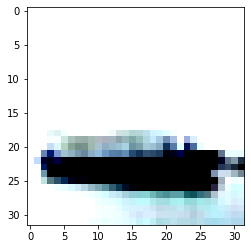

In [13]:
show_img(train_dataset[90])

In [14]:
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [15]:
test_dataset = CifarDataset(data, labels, transform_test)

# Model

In [18]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

In [19]:
teacher_model = WideResNet(16, 10, 2)
student_model = WideResNet(16, 10, 1)

teacher_model.to(device)
student_model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

In [20]:
teacher_model.load_state_dict(torch.load("./best_model_wrn16-2.pt"))

<All keys matched successfully>

In [21]:
for step, (images, labels) in enumerate(train_loader):
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.long)
    break

student_logits, student_features = student_model(images)
teacher_logits, teacher_features = teacher_model(images)

In [22]:
student_model = create_link(student_model, student_features[0].size(1), teacher_features[0].size(1), len(student_features))

In [23]:
student_model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

In [24]:
class TOFDLoss(nn.Module):
    def __init__(self, criterion, alpha, beta, device=None):
        super().__init__()
        self.criterion = criterion
        self.alpha = alpha
        self.beta = beta
        self.device = device

    def orthogonal_loss(self, link):
        loss = 0
        for layer in link:
            weight = list(layer.parameters())[0]
            weight_trans = weight.permute(1, 0)
            ones = torch.eye(weight.size(0)).to(self.device)
            ones2 = torch.eye(weight.size(1)).to(self.device)
            loss += torch.dist(torch.mm(weight, weight_trans), ones, p=2)
            loss += torch.dist(torch.mm(weight_trans, weight), ones2, p=2)
        
        return loss

    @staticmethod
    def logit_loss(student_logit, teacher_logit, T):
        log_softmax_outputs = F.log_softmax(student_logit/T, dim=1)
        softmax_targets = F.softmax(teacher_logit/T, dim=1)
        loss = -(log_softmax_outputs * softmax_targets).sum(dim=1).mean()
        return loss

    @staticmethod
    def feature_loss(student_feature, teacher_feature):
        loss = torch.dist(student_feature, teacher_feature, p=2)
        return loss

    @staticmethod
    def task_loss(student_logit, labels, criterion):
        loss = criterion(student_logit, labels)
        return loss

    def forward(self, student_features, teacher_features, student_logits, teacher_logits, labels, temperature, link):
        if self.device:
            loss = torch.FloatTensor([0.]).to(self.device)
        else:
            loss = torch.FloatTensor([0.])

        for index in range(len(student_features)):
            student_feature = link[index](student_features[index])
            loss += self.task_loss(student_logits[index], labels, self.criterion)
            loss += self.alpha * self.feature_loss(student_feature, teacher_features[index])
            loss += self.logit_loss(student_logits[index], teacher_logits[index], temperature)

        loss += self.beta * self.orthogonal_loss(link)
        return loss

In [25]:
tofd_loss = TOFDLoss(nn.CrossEntropyLoss(), 0.05, 0.03, device)

# Helper Functions

In [26]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [27]:
def train_fn(train_loader, teacher_model, student_model, criterion, t, epoch, optimizer, device):
    """
    Training a single epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    student_model.train()
    teacher_model.eval()
    
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        batch_size = labels.size(0)

        student_logits, student_features = student_model(images)
        teacher_logits, teacher_features = teacher_model(images)

        temperature = 1 + (t / 250) * float(1+epoch)

        loss = criterion(student_features, teacher_features, student_logits, teacher_logits, labels, temperature, student_model.link)
        
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg

In [28]:
def valid_fn(test_loader, teacher_model, student_model, criterion, t, epoch, device):
    """
    Validate after training an epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    teacher_model.eval()
    student_model.eval()
    
    start = end = time.time()
    preds = []
    valid_labels = []
    for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        batch_size = labels.size(0)

        with torch.no_grad():
            student_logits, student_features = student_model(images)
            teacher_logits, teacher_features = teacher_model(images)
        
        temperature = 1 + (t / 250) * float(1+epoch)
        loss = criterion(student_features, teacher_features, student_logits, teacher_logits, labels, temperature, student_model.link)
        
        losses.update(loss.item(), batch_size)

        preds.append(student_logits[0].softmax(1).to('cpu').numpy())
        valid_labels.append(labels.to('cpu').numpy())
        
        batch_time.update(time.time() - end)
        end = time.time()

    predictions = np.concatenate(preds)
    valid_labels = np.concatenate(valid_labels)
    
    score = get_score(valid_labels, predictions.argmax(1))
    
    return losses.avg, score

In [29]:
optimizer = SGD(student_model.parameters(), lr=0.1, weight_decay=5e-4, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2, verbose=False)
#scheduler = MultiStepLR(optimizer, milestones=[80, 160, 240], gamma=0.1, verbose=True)

In [30]:
best_score = 0

for epoch in range(200):
    
    start_time = time.time()
    
    avg_loss = train_fn(train_loader, teacher_model, student_model, tofd_loss, 3, epoch, optimizer, device)
    avg_val_loss, score = valid_fn(valid_loader, teacher_model, student_model, tofd_loss, 3, epoch, device)
    
    scheduler.step()
    print(f"Epoch {epoch+1}")
    print(f"Accuracy: {score} | Train loss: {avg_loss} | Valid loss: {avg_val_loss}")
    
    if score > best_score:
        # Save the model if the validation score is better
        print("YES")
        best_score = score
        torch.save(student_model.state_dict(), f"best_model_transfer.pt")
        
    elapsed = time.time() - start_time

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.02it/s]

Epoch 1
Accuracy: 0.539863782051282 | Train loss: 16.31990411003091 | Valid loss: 16.17471032264905
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.66it/s]

Epoch 2
Accuracy: 0.664863782051282 | Train loss: 14.32789318106453 | Valid loss: 14.63281942025209
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.14it/s]


Epoch 3
Accuracy: 0.710136217948718 | Train loss: 13.603433111793974 | Valid loss: 14.031256260016026
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.03it/s]

Epoch 4
Accuracy: 0.663261217948718 | Train loss: 13.203015987689678 | Valid loss: 14.38616310021816



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.56it/s]

Epoch 5
Accuracy: 0.7516025641025641 | Train loss: 12.91483298190299 | Valid loss: 13.390278693957207
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.68it/s]

Epoch 6
Accuracy: 0.7616185897435898 | Train loss: 12.730538188901722 | Valid loss: 13.380906838637133
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.96it/s]

Epoch 7
Accuracy: 0.7652243589743589 | Train loss: 12.572522649737845 | Valid loss: 13.349796661963829
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.30it/s]

Epoch 8
Accuracy: 0.7391826923076923 | Train loss: 12.442098984351524 | Valid loss: 13.6068754196167



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.98it/s]

Epoch 9
Accuracy: 0.7163461538461539 | Train loss: 12.332423856795003 | Valid loss: 13.881320439852201



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 12.35it/s]

Epoch 10
Accuracy: 0.7720352564102564 | Train loss: 12.281941166630498 | Valid loss: 13.095532392844175
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.23it/s]

Epoch 11
Accuracy: 0.7672275641025641 | Train loss: 12.179304954333183 | Valid loss: 13.121070274939903



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.60it/s]

Epoch 12
Accuracy: 0.7095352564102564 | Train loss: 12.105627353374775 | Valid loss: 13.765711759909605



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.08it/s]

Epoch 13
Accuracy: 0.7754407051282052 | Train loss: 12.070514567557224 | Valid loss: 13.38512684748723
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.46it/s]

Epoch 14
Accuracy: 0.741386217948718 | Train loss: 12.019937257141809 | Valid loss: 13.532167703677446



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.11it/s]

Epoch 15
Accuracy: 0.8155048076923077 | Train loss: 11.968478094138991 | Valid loss: 12.453227556668795
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.06it/s]

Epoch 16
Accuracy: 0.7790464743589743 | Train loss: 11.923267141706244 | Valid loss: 12.877213747073442



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.75it/s]

Epoch 17
Accuracy: 0.733573717948718 | Train loss: 11.906275010176874 | Valid loss: 13.191289730561085



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.49it/s]

Epoch 18
Accuracy: 0.8100961538461539 | Train loss: 11.85604383734896 | Valid loss: 12.43777216397799



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.23it/s]

Epoch 19
Accuracy: 0.7690304487179487 | Train loss: 11.792175477726168 | Valid loss: 13.060308921031464



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.77it/s]

Epoch 20
Accuracy: 0.7946714743589743 | Train loss: 11.781666062835955 | Valid loss: 12.818255008795322



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.80it/s]

Epoch 21
Accuracy: 0.7550080128205128 | Train loss: 11.737211988182828 | Valid loss: 13.125405311584473



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.77it/s]

Epoch 22
Accuracy: 0.8263221153846154 | Train loss: 11.734255687463657 | Valid loss: 12.56886589832795
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.59it/s]

Epoch 23
Accuracy: 0.8147035256410257 | Train loss: 11.69166281012728 | Valid loss: 12.410995067694248



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.68it/s]

Epoch 24
Accuracy: 0.7598157051282052 | Train loss: 11.636200627710066 | Valid loss: 13.417074032318897



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.94it/s]

Epoch 25
Accuracy: 0.7934695512820513 | Train loss: 11.629362780144412 | Valid loss: 12.698622018862993



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.91it/s]

Epoch 26
Accuracy: 0.7828525641025641 | Train loss: 11.625886873641925 | Valid loss: 12.892473440903883



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.05it/s]

Epoch 27
Accuracy: 0.8313301282051282 | Train loss: 11.572100726287928 | Valid loss: 12.323618130806166
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.05it/s]

Epoch 28
Accuracy: 0.8407451923076923 | Train loss: 11.592752679460748 | Valid loss: 12.471481836759127
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.76it/s]

Epoch 29
Accuracy: 0.8371394230769231 | Train loss: 11.542857642866608 | Valid loss: 12.045974242381561



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.84it/s]

Epoch 30
Accuracy: 0.7526041666666666 | Train loss: 11.503690888059785 | Valid loss: 13.35602276141827



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.48it/s]

Epoch 31
Accuracy: 0.8102964743589743 | Train loss: 11.529712878061495 | Valid loss: 12.371694002396021



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.00it/s]

Epoch 32
Accuracy: 0.8030849358974359 | Train loss: 11.485575007577228 | Valid loss: 12.46743383163061



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.90it/s]

Epoch 33
Accuracy: 0.8213141025641025 | Train loss: 11.495753271966917 | Valid loss: 12.580294364537949



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.17it/s]

Epoch 34
Accuracy: 0.8157051282051282 | Train loss: 11.488325890652474 | Valid loss: 12.166238124553974



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.83it/s]

Epoch 35
Accuracy: 0.8094951923076923 | Train loss: 11.446288904912791 | Valid loss: 12.662064112149752



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.66it/s]

Epoch 36
Accuracy: 0.8465544871794872 | Train loss: 11.448484594665702 | Valid loss: 12.198920274392153
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.35it/s]

Epoch 37
Accuracy: 0.7612179487179487 | Train loss: 11.410512986685815 | Valid loss: 12.764957330165766



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.11it/s]

Epoch 38
Accuracy: 0.8036858974358975 | Train loss: 11.414832563481779 | Valid loss: 12.417421585474258



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.38it/s]

Epoch 39
Accuracy: 0.8060897435897436 | Train loss: 11.391484918078126 | Valid loss: 12.202722231547037



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.16it/s]

Epoch 40
Accuracy: 0.7223557692307693 | Train loss: 11.378490888155424 | Valid loss: 13.404405153714693



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.01it/s]

Epoch 41
Accuracy: 0.8305288461538461 | Train loss: 11.378144595697734 | Valid loss: 11.958726369417631



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.72it/s]

Epoch 42
Accuracy: 0.8205128205128205 | Train loss: 11.34831061730018 | Valid loss: 12.099605315770859



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.82it/s]

Epoch 43
Accuracy: 0.803886217948718 | Train loss: 11.36479004427918 | Valid loss: 11.98410743322128



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.94it/s]

Epoch 44
Accuracy: 0.7431891025641025 | Train loss: 11.334528808919792 | Valid loss: 12.943105159661709



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.47it/s]

Epoch 45
Accuracy: 0.7936698717948718 | Train loss: 11.33321444193522 | Valid loss: 12.656520158816607



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.70it/s]

Epoch 46
Accuracy: 0.8145032051282052 | Train loss: 11.33775803166577 | Valid loss: 12.512971120002943



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.31it/s]

Epoch 47
Accuracy: 0.8525641025641025 | Train loss: 11.29444566275659 | Valid loss: 12.741747538248697
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.35it/s]

Epoch 48
Accuracy: 0.8489583333333334 | Train loss: 11.274618917720609 | Valid loss: 11.863423885443272



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.27it/s]

Epoch 49
Accuracy: 0.7748397435897436 | Train loss: 11.310861815754166 | Valid loss: 12.69833838634002



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.81it/s]

Epoch 50
Accuracy: 0.7918669871794872 | Train loss: 11.282438479257785 | Valid loss: 12.598539254604242



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.02it/s]

Epoch 51
Accuracy: 0.850761217948718 | Train loss: 11.293691406902084 | Valid loss: 12.042256233019707



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.26it/s]

Epoch 52
Accuracy: 0.8135016025641025 | Train loss: 11.310543899862175 | Valid loss: 12.163276623456905



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.13it/s]

Epoch 53
Accuracy: 0.836738782051282 | Train loss: 11.242849032084147 | Valid loss: 12.570637018252642



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.64it/s]

Epoch 54
Accuracy: 0.8261217948717948 | Train loss: 11.260363991783555 | Valid loss: 12.324327517778446



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.25it/s]

Epoch 55
Accuracy: 0.8387419871794872 | Train loss: 11.25779107629064 | Valid loss: 11.750370759230394



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.16it/s]

Epoch 56
Accuracy: 0.8307291666666666 | Train loss: 11.243999660524548 | Valid loss: 11.992069391103891



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.52it/s]

Epoch 57
Accuracy: 0.8383413461538461 | Train loss: 11.233881396106165 | Valid loss: 12.002980452317457



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.91it/s]

Epoch 58
Accuracy: 0.7878605769230769 | Train loss: 11.222925525784833 | Valid loss: 12.528034968253893



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.17it/s]

Epoch 59
Accuracy: 0.8271233974358975 | Train loss: 11.222174473297901 | Valid loss: 12.195931190099472



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.02it/s]

Epoch 60
Accuracy: 0.803886217948718 | Train loss: 11.238143263379394 | Valid loss: 12.634991548000238



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.26it/s]


Epoch 61
Accuracy: 0.9202724358974359 | Train loss: 10.499288792623753 | Valid loss: 10.44348949041122
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.12it/s]

Epoch 62
Accuracy: 0.9186698717948718 | Train loss: 10.353954532547215 | Valid loss: 10.349683737143492



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.78it/s]

Epoch 63
Accuracy: 0.9158653846153846 | Train loss: 10.296067110154024 | Valid loss: 10.334934185712765



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 12.55it/s]

Epoch 64
Accuracy: 0.9170673076923077 | Train loss: 10.269245044458286 | Valid loss: 10.430252808790941



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.15it/s]

Epoch 65
Accuracy: 0.9140625 | Train loss: 10.254373615623539 | Valid loss: 10.414687278943184



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.35it/s]

Epoch 66
Accuracy: 0.9016426282051282 | Train loss: 10.242554542345879 | Valid loss: 10.67995467552772



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.80it/s]

Epoch 67
Accuracy: 0.9078525641025641 | Train loss: 10.236943318293644 | Valid loss: 10.512830049563677



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.26it/s]

Epoch 68
Accuracy: 0.9146634615384616 | Train loss: 10.236371502237782 | Valid loss: 10.413783415769919



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.52it/s]

Epoch 69
Accuracy: 0.9164663461538461 | Train loss: 10.210129957932692 | Valid loss: 10.400131788009253



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.01it/s]

Epoch 70
Accuracy: 0.9098557692307693 | Train loss: 10.22947725747046 | Valid loss: 10.368182524656637



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.05it/s]

Epoch 71
Accuracy: 0.9102564102564102 | Train loss: 10.225397854449064 | Valid loss: 10.492746377602602



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.67it/s]

Epoch 72
Accuracy: 0.9076522435897436 | Train loss: 10.227032074561485 | Valid loss: 10.53343146886581



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.97it/s]

Epoch 73
Accuracy: 0.9114583333333334 | Train loss: 10.213821234526458 | Valid loss: 10.551949354318472



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.98it/s]

Epoch 74
Accuracy: 0.9112580128205128 | Train loss: 10.222075302037078 | Valid loss: 10.550267830873148



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.26it/s]

Epoch 75
Accuracy: 0.9116586538461539 | Train loss: 10.23577565684957 | Valid loss: 10.457714325342423



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.35it/s]

Epoch 76
Accuracy: 0.8998397435897436 | Train loss: 10.231817783453526 | Valid loss: 10.59912547087058



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.98it/s]

Epoch 77
Accuracy: 0.9184695512820513 | Train loss: 10.22420169417335 | Valid loss: 10.349472363789877



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.43it/s]

Epoch 78
Accuracy: 0.9134615384615384 | Train loss: 10.225313594198635 | Valid loss: 10.39711776146522



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.80it/s]

Epoch 79
Accuracy: 0.9138621794871795 | Train loss: 10.222233035965184 | Valid loss: 10.433973043392866



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.28it/s]

Epoch 80
Accuracy: 0.9194711538461539 | Train loss: 10.233140195536818 | Valid loss: 10.393143604963253



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.13it/s]

Epoch 81
Accuracy: 0.9080528846153846 | Train loss: 10.242734664525742 | Valid loss: 10.43344874259753



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.88it/s]

Epoch 82
Accuracy: 0.9016426282051282 | Train loss: 10.247955194565645 | Valid loss: 10.58053197616186



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.56it/s]

Epoch 83
Accuracy: 0.8866185897435898 | Train loss: 10.221376079439777 | Valid loss: 10.961890171735714



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.90it/s]

Epoch 84
Accuracy: 0.90625 | Train loss: 10.234955855584213 | Valid loss: 10.451472624754294



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.69it/s]

Epoch 85
Accuracy: 0.9066506410256411 | Train loss: 10.237514167090087 | Valid loss: 10.679684052100548



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.82it/s]

Epoch 86
Accuracy: 0.9014423076923077 | Train loss: 10.21656360789242 | Valid loss: 10.538098653157553



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.70it/s]

Epoch 87
Accuracy: 0.8962339743589743 | Train loss: 10.225674754194385 | Valid loss: 10.807036839998686



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.73it/s]

Epoch 88
Accuracy: 0.8770032051282052 | Train loss: 10.227114574182407 | Valid loss: 10.976776098593687



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.71it/s]

Epoch 89
Accuracy: 0.9024439102564102 | Train loss: 10.235975064443387 | Valid loss: 10.596765298109789



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.37it/s]

Epoch 90
Accuracy: 0.9012419871794872 | Train loss: 10.223595380103825 | Valid loss: 10.531334290137657



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.42it/s]

Epoch 91
Accuracy: 0.9036458333333334 | Train loss: 10.214370515611437 | Valid loss: 10.499804032154572



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 13.04it/s]

Epoch 92
Accuracy: 0.890625 | Train loss: 10.210042377482791 | Valid loss: 10.85765388684395



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.57it/s]

Epoch 93
Accuracy: 0.8936298076923077 | Train loss: 10.216273946300191 | Valid loss: 10.599116252018856



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.47it/s]

Epoch 94
Accuracy: 0.9044471153846154 | Train loss: 10.228669544230838 | Valid loss: 10.77418674566807



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.12it/s]

Epoch 95
Accuracy: 0.9090544871794872 | Train loss: 10.19915488370803 | Valid loss: 10.633256178635817



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 14.18it/s]

Epoch 98
Accuracy: 0.9048477564102564 | Train loss: 10.206429736906307 | Valid loss: 10.528751446650578



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.72it/s]

Epoch 99
Accuracy: 0.8884214743589743 | Train loss: 10.203220959742184 | Valid loss: 10.885487703176645



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.73it/s]

Epoch 100
Accuracy: 0.9024439102564102 | Train loss: 10.207924451583471 | Valid loss: 10.615299371572641



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.20it/s]

Epoch 101
Accuracy: 0.9124599358974359 | Train loss: 10.202476140101071 | Valid loss: 10.388497988382975



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.82it/s]

Epoch 102
Accuracy: 0.9094551282051282 | Train loss: 10.207549978185583 | Valid loss: 10.56031518104749



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.97it/s]

Epoch 103
Accuracy: 0.875 | Train loss: 10.203363527259935 | Valid loss: 10.99126984522893



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.06it/s]

Epoch 104
Accuracy: 0.9080528846153846 | Train loss: 10.234552839882353 | Valid loss: 10.46833945543338



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.93it/s]

Epoch 105
Accuracy: 0.8527644230769231 | Train loss: 10.20280463878925 | Valid loss: 11.345543812482784



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.73it/s]

Epoch 106
Accuracy: 0.8938301282051282 | Train loss: 10.190399245998458 | Valid loss: 10.83346166366186



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.89it/s]

Epoch 107
Accuracy: 0.8784054487179487 | Train loss: 10.209586143493652 | Valid loss: 10.84803815988394



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.91it/s]

Epoch 108
Accuracy: 0.8802083333333334 | Train loss: 10.220171287188842 | Valid loss: 11.07115518129789



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.89it/s]

Epoch 109
Accuracy: 0.9114583333333334 | Train loss: 10.193471001084374 | Valid loss: 10.396281780340733



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 13.61it/s]

Epoch 110
Accuracy: 0.9022435897435898 | Train loss: 10.192775430163087 | Valid loss: 10.518257385645157



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.34it/s]

Epoch 111
Accuracy: 0.882011217948718 | Train loss: 10.210580024284514 | Valid loss: 10.897562075883915



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.40it/s]

Epoch 112
Accuracy: 0.9034455128205128 | Train loss: 10.197930292526202 | Valid loss: 10.435384897085337



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.64it/s]

Epoch 113
Accuracy: 0.9058493589743589 | Train loss: 10.20834162296393 | Valid loss: 10.649545473930162



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.45it/s]

Epoch 114
Accuracy: 0.8912259615384616 | Train loss: 10.206791606044497 | Valid loss: 10.662623576628857



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.30it/s]

Epoch 115
Accuracy: 0.9002403846153846 | Train loss: 10.222853231294202 | Valid loss: 10.513703908675756



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.25it/s]

Epoch 116
Accuracy: 0.9102564102564102 | Train loss: 10.217835828449651 | Valid loss: 10.549288823054386



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.97it/s]

Epoch 117
Accuracy: 0.9030448717948718 | Train loss: 10.204862629925763 | Valid loss: 10.632944204868414



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.88it/s]

Epoch 118
Accuracy: 0.9002403846153846 | Train loss: 10.21607944564602 | Valid loss: 10.630162899310772



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.89it/s]

Epoch 119
Accuracy: 0.907051282051282 | Train loss: 10.21255485013 | Valid loss: 10.560745654962002



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 14.30it/s]

Epoch 120
Accuracy: 0.9048477564102564 | Train loss: 10.21431998174075 | Valid loss: 10.688580928704678



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.25it/s]

Epoch 121
Accuracy: 0.9290865384615384 | Train loss: 9.887698700624993 | Valid loss: 9.885017884083283
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.93it/s]

Epoch 122
Accuracy: 0.9306891025641025 | Train loss: 9.826519735178717 | Valid loss: 9.844321153102777
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.60it/s]

Epoch 123
Accuracy: 0.9332932692307693 | Train loss: 9.806838619742978 | Valid loss: 9.838529684604742
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.72it/s]


Epoch 124
Accuracy: 0.9336939102564102 | Train loss: 9.78972629264549 | Valid loss: 9.837135290488218
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.95it/s]

Epoch 125
Accuracy: 0.9360977564102564 | Train loss: 9.789403673590419 | Valid loss: 9.882691212189503
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.28it/s]

Epoch 126
Accuracy: 0.9336939102564102 | Train loss: 9.784940831002347 | Valid loss: 9.889562484545586



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.66it/s]


Epoch 127
Accuracy: 0.9372996794871795 | Train loss: 9.771511156674464 | Valid loss: 9.831494037921612
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.53it/s]

Epoch 128
Accuracy: 0.9342948717948718 | Train loss: 9.773787897876185 | Valid loss: 9.8496462504069



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.57it/s]


Epoch 129
Accuracy: 0.9352964743589743 | Train loss: 9.7699282230475 | Valid loss: 9.92194173274896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.68it/s]

Epoch 130
Accuracy: 0.9320913461538461 | Train loss: 9.766263190158073 | Valid loss: 9.857490612910343



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.55it/s]

Epoch 131
Accuracy: 0.9316907051282052 | Train loss: 9.763511589789323 | Valid loss: 9.829032604510967



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.42it/s]

Epoch 132
Accuracy: 0.9370993589743589 | Train loss: 9.759565203957408 | Valid loss: 9.844617819174742



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.45it/s]

Epoch 133
Accuracy: 0.9362980769230769 | Train loss: 9.76664576842914 | Valid loss: 9.836574334364672



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.53it/s]

Epoch 134
Accuracy: 0.9336939102564102 | Train loss: 9.778415378342327 | Valid loss: 9.837091079125038



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.12it/s]

Epoch 135
Accuracy: 0.9358974358974359 | Train loss: 9.77446580272794 | Valid loss: 9.875757290766789



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.52it/s]

Epoch 136
Accuracy: 0.9368990384615384 | Train loss: 9.768136584181391 | Valid loss: 9.842428403022963



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.56it/s]


Epoch 137
Accuracy: 0.9375 | Train loss: 9.76914750884401 | Valid loss: 9.830722955557016
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 14.86it/s]

Epoch 138
Accuracy: 0.9381009615384616 | Train loss: 9.763469133621607 | Valid loss: 9.850576914273775
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.04it/s]

Epoch 139
Accuracy: 0.9354967948717948 | Train loss: 9.767169414422451 | Valid loss: 9.841849669432028



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.18it/s]

Epoch 140
Accuracy: 0.9358974358974359 | Train loss: 9.773715290928159 | Valid loss: 9.862750420203575



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.47it/s]

Epoch 141
Accuracy: 0.9326923076923077 | Train loss: 9.779073448941919 | Valid loss: 9.866251676510542



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.38it/s]

Epoch 142
Accuracy: 0.9344951923076923 | Train loss: 9.782563209533691 | Valid loss: 9.869409463344477



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.61it/s]

Epoch 143
Accuracy: 0.9354967948717948 | Train loss: 9.779850804907644 | Valid loss: 9.882089786040478



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.82it/s]

Epoch 144
Accuracy: 0.9312900641025641 | Train loss: 9.783720347956034 | Valid loss: 9.932698543255146



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.34it/s]

Epoch 145
Accuracy: 0.9338942307692307 | Train loss: 9.771968580718733 | Valid loss: 9.885396615052835



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.74it/s]

Epoch 146
Accuracy: 0.9330929487179487 | Train loss: 9.773698029694733 | Valid loss: 9.898613905295347



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.99it/s]


Epoch 147
Accuracy: 0.9354967948717948 | Train loss: 9.777074335647105 | Valid loss: 9.925583448165503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.52it/s]

Epoch 148
Accuracy: 0.9340945512820513 | Train loss: 9.793575968837466 | Valid loss: 9.962063789367676



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.65it/s]

Epoch 149
Accuracy: 0.9312900641025641 | Train loss: 9.788880513943838 | Valid loss: 9.894741474053799



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 10.93it/s]

Epoch 150
Accuracy: 0.9330929487179487 | Train loss: 9.789055174911804 | Valid loss: 9.921325047810873



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.58it/s]

Epoch 151
Accuracy: 0.9312900641025641 | Train loss: 9.796754687599986 | Valid loss: 10.01725380237286



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.28it/s]

Epoch 152
Accuracy: 0.9310897435897436 | Train loss: 9.78655655363686 | Valid loss: 9.937918247320713



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.67it/s]

Epoch 153
Accuracy: 0.9336939102564102 | Train loss: 9.812865004580246 | Valid loss: 9.948216780638083



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 14.97it/s]

Epoch 154
Accuracy: 0.9326923076923077 | Train loss: 9.798897680733619 | Valid loss: 9.927331924438477



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.71it/s]

Epoch 155
Accuracy: 0.9302884615384616 | Train loss: 9.81253265859055 | Valid loss: 10.013395358354618



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.04it/s]

Epoch 156
Accuracy: 0.936698717948718 | Train loss: 9.818704227436642 | Valid loss: 10.010414025722406



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.65it/s]

Epoch 157
Accuracy: 0.9318910256410257 | Train loss: 9.810680601331923 | Valid loss: 9.983947680546688



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.19it/s]

Epoch 158
Accuracy: 0.9330929487179487 | Train loss: 9.818536098186787 | Valid loss: 9.943396519391964



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 12.84it/s]

Epoch 159
Accuracy: 0.9350961538461539 | Train loss: 9.81830213823889 | Valid loss: 9.973706538860615



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.72it/s]

Epoch 160
Accuracy: 0.9312900641025641 | Train loss: 9.807321105587516 | Valid loss: 10.000901148869442



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.56it/s]


Epoch 161
Accuracy: 0.9411057692307693 | Train loss: 9.733654489544382 | Valid loss: 9.773668142465445
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.96it/s]

Epoch 162
Accuracy: 0.9409054487179487 | Train loss: 9.725364429658635 | Valid loss: 9.77918764261099



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.94it/s]

Epoch 163
Accuracy: 0.9401041666666666 | Train loss: 9.715914709955198 | Valid loss: 9.78553246229123



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.10it/s]

Epoch 164
Accuracy: 0.9419070512820513 | Train loss: 9.709257563294848 | Valid loss: 9.768082056290064
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.76it/s]

Epoch 165
Accuracy: 0.9393028846153846 | Train loss: 9.71946649741583 | Valid loss: 9.770383125696426



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.46it/s]

Epoch 166
Accuracy: 0.9411057692307693 | Train loss: 9.71802594383218 | Valid loss: 9.776070545881222



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.43it/s]

Epoch 167
Accuracy: 0.9399038461538461 | Train loss: 9.719862473316681 | Valid loss: 9.777919744833921



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.93it/s]

Epoch 168
Accuracy: 0.9407051282051282 | Train loss: 9.730615344142642 | Valid loss: 9.78037858620668



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.65it/s]

Epoch 169
Accuracy: 0.9409054487179487 | Train loss: 9.720718171861437 | Valid loss: 9.784686479813013



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 15.58it/s]


Epoch 170
Accuracy: 0.9407051282051282 | Train loss: 9.720414881692653 | Valid loss: 9.78807992201585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.26it/s]

Epoch 171
Accuracy: 0.9411057692307693 | Train loss: 9.724804693477445 | Valid loss: 9.786411578838642



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.08it/s]

Epoch 172
Accuracy: 0.9409054487179487 | Train loss: 9.738204081173976 | Valid loss: 9.803522868034166



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.41it/s]


Epoch 173
Accuracy: 0.9425080128205128 | Train loss: 9.731596514709995 | Valid loss: 9.806469599405924
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.71it/s]

Epoch 174
Accuracy: 0.9407051282051282 | Train loss: 9.731976859589928 | Valid loss: 9.786490635994154



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.34it/s]

Epoch 175
Accuracy: 0.9417067307692307 | Train loss: 9.74732407409581 | Valid loss: 9.796372486994816



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.36it/s]

Epoch 176
Accuracy: 0.9417067307692307 | Train loss: 9.740981341087581 | Valid loss: 9.795117353781675



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.73it/s]

Epoch 177
Accuracy: 0.9423076923076923 | Train loss: 9.740902645295842 | Valid loss: 9.814876629756046



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 12.98it/s]

Epoch 178
Accuracy: 0.9391025641025641 | Train loss: 9.746225096221663 | Valid loss: 9.814991095127203



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 14.50it/s]

Epoch 179
Accuracy: 0.9401041666666666 | Train loss: 9.757015739071402 | Valid loss: 9.80347239665496



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.71it/s]

Epoch 180
Accuracy: 0.9405048076923077 | Train loss: 9.748353800542674 | Valid loss: 9.817890680753267



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.53it/s]

Epoch 181
Accuracy: 0.9405048076923077 | Train loss: 9.758678623753735 | Valid loss: 9.813589658492651



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.78it/s]

Epoch 182
Accuracy: 0.9413060897435898 | Train loss: 9.751950014011133 | Valid loss: 9.813443379524427



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.35it/s]

Epoch 183
Accuracy: 0.9413060897435898 | Train loss: 9.762276793477202 | Valid loss: 9.816417449559921



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.47it/s]

Epoch 184
Accuracy: 0.9407051282051282 | Train loss: 9.763767201676329 | Valid loss: 9.822477022806803



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.65it/s]

Epoch 185
Accuracy: 0.9411057692307693 | Train loss: 9.766658117288877 | Valid loss: 9.827921745104668



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.87it/s]

Epoch 186
Accuracy: 0.9407051282051282 | Train loss: 9.770694950027684 | Valid loss: 9.822600633670122



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.39it/s]

Epoch 187
Accuracy: 0.9411057692307693 | Train loss: 9.782838288875046 | Valid loss: 9.826995433905186



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.42it/s]

Epoch 188
Accuracy: 0.9419070512820513 | Train loss: 9.77199582428674 | Valid loss: 9.829974150046324



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.79it/s]

Epoch 189
Accuracy: 0.9403044871794872 | Train loss: 9.775757629307586 | Valid loss: 9.842377246954502



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.80it/s]

Epoch 190
Accuracy: 0.9441105769230769 | Train loss: 9.77742441019781 | Valid loss: 9.83043394333277
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.01it/s]

Epoch 191
Accuracy: 0.9419070512820513 | Train loss: 9.782323562861167 | Valid loss: 9.84480777153602



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.03it/s]

Epoch 192
Accuracy: 0.9431089743589743 | Train loss: 9.78005983347227 | Valid loss: 9.850514167394394



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.50it/s]

Epoch 193
Accuracy: 0.9435096153846154 | Train loss: 9.794060704375264 | Valid loss: 9.834480481270033



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.88it/s]

Epoch 194
Accuracy: 0.9429086538461539 | Train loss: 9.795547428294125 | Valid loss: 9.855229940169897



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.35it/s]

Epoch 195
Accuracy: 0.9415064102564102 | Train loss: 9.793300867759944 | Valid loss: 9.856235039539825



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.62it/s]

Epoch 196
Accuracy: 0.9427083333333334 | Train loss: 9.79905202653673 | Valid loss: 9.856479693681766



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.63it/s]

Epoch 197
Accuracy: 0.9417067307692307 | Train loss: 9.802242257316568 | Valid loss: 9.858611278044872



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.51it/s]

Epoch 198
Accuracy: 0.9439102564102564 | Train loss: 9.80605295241049 | Valid loss: 9.864297646742601



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.55it/s]

Epoch 199
Accuracy: 0.9415064102564102 | Train loss: 9.81765696805427 | Valid loss: 9.877943723629683



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.87it/s]


Epoch 200
Accuracy: 0.9407051282051282 | Train loss: 9.802544202560034 | Valid loss: 9.86153954725999


In [31]:
torch.save(student_model.state_dict(), f"last_model_transfer.pt")

In [40]:
student_model.load_state_dict(torch.load("./best_model_transfer.pt"))

<All keys matched successfully>

In [41]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                          num_workers=4, pin_memory=True, drop_last=False)

In [42]:
preds = []
valid_labels = []

student_model.eval()
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        logits, features = student_model(images)
        
    preds.append(logits[0].softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = get_score(valid_labels, predictions.argmax(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.36it/s]


In [43]:
score

0.9217